# SIGNAL PROCESSING

In [1]:
import numpy as np
import mne
import pyxdf  # load file.xdf
import pandas as pd

# enable interactive plotting
%matplotlib widget  

## Get the Data
- Extract data streams from file.xdf

In [2]:
# DATA PATHS

# MONTAGE FILE
MONTAGE = 'DATA/montage_perfect.csv'
#
PILOTS_TOBIAS = 'DATA/Pilots_Tobias_05.10.22/'
PILOTS_THIBAUT = 'DATA/Pilots_Thibaut_06.10.22/'
#
BASELINE_EC_THIBAUT = 'sub-Thibaut_eegBaseline_eyesclosed.xdf'
BASELINE_EC_TOBIAS = 'sub-Tobias_eegBaseline_eyesclosed.xdf'
PASSIVE_TOBIAS = 'sub-Tobias_passiveOA.xdf'
PASSIVE_THIBAUT = 'sub-Thibaut_passiveOA_2.xdf'

# load file.xdf to numpy ndarray

# xdf_file = PILOTS_THIBAUT+PASSIVE_THIBAUT
# xdf_file = PILOTS_TOBIAS+PASSIVE_TOBIAS

xdf_file = 'DATA/Pilot_Daniel_11.10.22/sub-Passive_observation_2_Daniel.xdf'
streams, header = pyxdf.load_xdf(xdf_file)

Stream 6: Calculated effective sampling rate 849.3053 Hz is different from specified rate 999.9999 Hz.


## Filter raw data  
- Create mne.io.RawArray
- Discard bad channels (manually)
- BP filter
- CAR filter

In [7]:
def get_index_of_stream_type(streams, type):
    """
    type = 'EEG', 'TargetID'
    return the index of the stream corresponding to the wanted type
    types : 'EEG', 'Markers', 'Unity.Property', 'Unity.Marker'(2 different),
    """
    if type == 'EEG': name = 'eegoSports 000650'
    elif type == 'TargetID': name = 'Unity.Marker.TargetID'
    else :
        raise NameError(
            f"given type '{type}' is not an argument. Accepted types are 'EEG' and 'TargetID'"
        )
    for i in range(len(streams)):
        if streams[i]['info']['name'][0] == name:
            return i
    raise NameError(
         f"given type '{type}' cannot be found in any of the streams"
    )

#### Create raw data
mt = pd.read_csv(MONTAGE)
ch_names = mt['ch_name'].tolist()
ch_names.append('weird_channel_65')

NB_CHANNELS = 64
EEG = get_index_of_stream_type(streams, type='EEG')

data = streams[EEG]["time_series"].copy().T  # data.shape = (nb_channels, nb_samples)
data *= 1e-6  # convert from uV to V (mne uses V)
print(len(data))
assert len(data) == NB_CHANNELS      
sfreq = float(streams[EEG]["info"]["nominal_srate"][0])
ch_types = ['eeg'] * 64 + ['misc']
info = mne.create_info(ch_names, sfreq, ch_types)
# info = mne.create_info(NB_CHANNELS, sfreq)
raw = mne.io.RawArray(data, info)


#### Handle bad channels

# discard channel [12] for 'sub-Tobias_passiveOA.xdf'
# (the channel should appear in grey on the plot)
if xdf_file == PILOTS_TOBIAS+PASSIVE_TOBIAS :
    raw.info['bads'].extend(['M1', 'weird_channel_65'])
    
# It's possible to select bads channels directly from the graph by clicking on them once 
# but need to CLOSE the figure to update mne.Info object
# Could be interesting to implement that in the process of processing all datas

raw.plot(scalings='auto');  # ";" to show ONLY interactive plot


#### BP filter on raw signal

rawBP = raw.copy().filter(l_freq=1.5, h_freq=40)
# rawBP.plot(); 


#### CAR (common average reference) filter 

rawBPCAR, ref_data = mne.set_eeg_reference(rawBP, ref_channels='average', copy=True)
# rawBPCAR.plot(); 

66


AssertionError: 

In [ ]:
# print(raw.info)

## Segmentation of the signal with mne.Epochs
Streams TargetID+time_stamps --> mne.Annotations --> events+event_ID --> mne.Epochs

                                   |--> rawannot -----^^^-------------^^^ 

Used Annotations descriptions: ['2', '5', '8']
Not setting metadata
35 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11 events and 12001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 11 events and 12001 original time points ...
Using data from preloaded Raw for 11 events and 12001 original time points ...


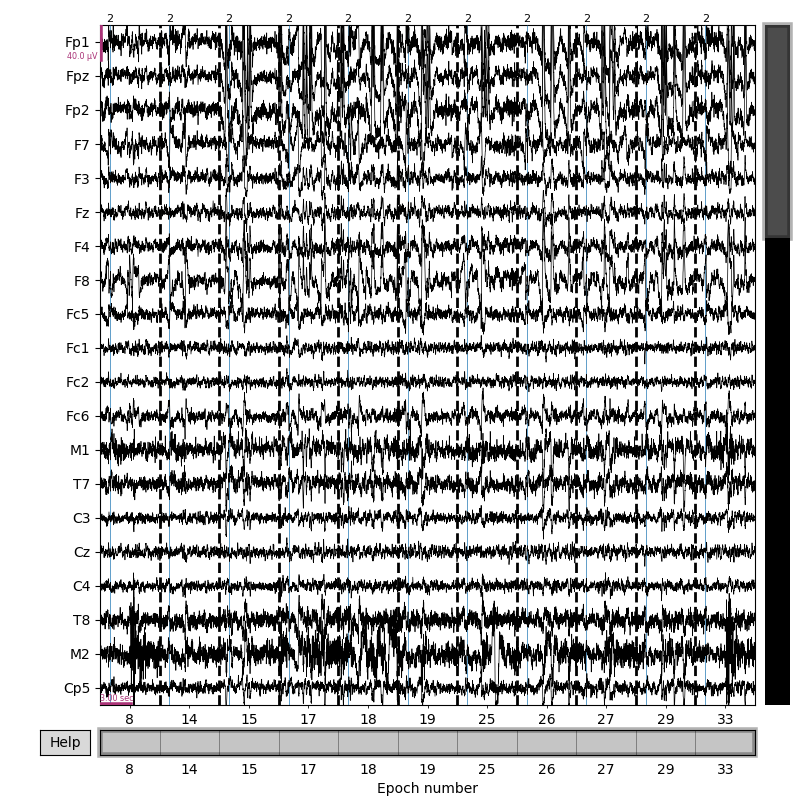

In [ ]:
# Create mne.Epochs from raw preprocessed signal

TIME_OFFSET = -1  # in sec, the event window begins x seconds before the time stamp
DUR = 5 # in sec, duration of the event window in seconds
TargetID = get_index_of_stream_type(streams, 'TargetID')


#### Create mne.Annotations from TargetID stream (with time_stamps)

t_origin = streams[EEG]['time_stamps'][0]
time_stamps = streams[TargetID]['time_stamps'] - t_origin  # signal begins at 0s
target_nb = np.array(streams[TargetID]['time_series']).squeeze()  # array with target IDs
annots = mne.Annotations(onset=time_stamps, duration=0., description=target_nb)  
# 0 duration for event : easier to transform to event and add a duration when creating mne.Epochs

# add annotations to the preprocessed raw signal
rawannot = rawBPCAR.copy().set_annotations(annots)


#### Create events from annotations

events, event_id = mne.events_from_annotations(rawannot)
# print(event_id)
# print(events)


#### Create mne.Epochs with events and event_ID
# also define the event window 

epochs = mne.Epochs(rawBPCAR, events, event_id, tmin=TIME_OFFSET, tmax=DUR, baseline=(TIME_OFFSET,0), reject=dict(eeg=400e-6))  # bad channels won't appear on graph
# baseline : for now we do a baseline correction with the second before the event as a reference
# reject : looks for each epoch for every channel individually, if PTP is above the given threshold the respective epoch is dropped

# plot one kind of event 
epochs['2'].plot(events=events, event_id=event_id); 

## TOPOPLOT

C:\Users\thiba\AppData\Local\Temp/ipykernel_21660/298899649.py:30: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked.info.set_montage(montage)


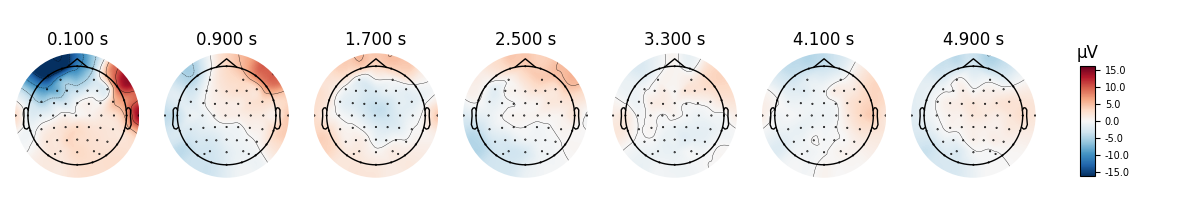

In [ ]:
#### Modify montage file so it is actually readable : 

# csv (with commas and not semicolons, had to change in windows advanced regional settings)
# add header bcs first row is discarded by mne
# ch_name column first
# exchange x and y columns
# ch_names with only first letter in uppercase
# final format : Ch_name,X,Y,Z

# import pandas as pd

# mt=pd.read_csv('DATA/montage.csv')
# mt['ch_name'] = mt['ch_name'].str.lower().str.title()
# mt=mt.reindex(columns=['ch_name', 'y', 'x', 'z'])
# mt=mt.rename(columns={'y':'x', 'x':'y'})
# mt.to_csv('DATA/montage_perfect.csv', index=False)


#### Montage

montage = mne.channels.read_custom_montage(MONTAGE) 
# montage.plot(sphere='eeglab');  # 'eeglab' argument to position electrodes automatically :D (only works with this specific file format)


#### Evoked data

evoked = epochs['5'].average()

# set_montage in mne.Info
evoked.info.set_montage(montage)


#### Topoplot

times = np.arange(0.1, 5, 0.8)
evoked.plot_topomap(times, sphere='eeglab'); 